# Project 3
Griffith Stites and Alex Hindelang

## Assumptions
* Ignoring temperature changes for the fluid and how this effects density. Just choosing based off of the ideal temperature from the engineeringtoolbox chart
* That the force of the penguin exerted on the fluid does not change based on fluid density.

# Question: How does changing the fluid in which a penguin swims alter its velocity, acceleration, and swim time?

We are modeling the motion of a penguin in olympic-sized swimming pool filled with different fluids to test how its motion is affected.

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# import matlab like plotting functions
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from scipy import signal

# Model

Our model uses force equations to derive the velocity and distance traveled of a penguin. It runs a simulation of the force of the penguin swimming versus the drag force and records the time it takes for the penguin to travel the length of an Olympic swimming pool.

In [3]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
km = UNITS.kilometer
hr = UNITS.hour
s = UNITS.second
N = UNITS.newton
;

''

Below, we declare the values of different liquid densities, denoted as rho, outside of the Params object so it can be easily altered.

We do the same for the mass of the penguin, so if we choose to add more species later we can alter it. The current penguin is the Gentoo penguin, which is the fastest of all penguins. We include the penguins mass, max speed, and the flapping speed of the penguin (Based off of watching a Gentoo penguin swim).

The other parameters are as follows:

C_d = Coeffient of drag of the penguin

frontal_area = The frontal area of the penguin

velocity_init = Starting velocity of the penguin

pool_length = Length of the pool (Based off an Olympic swimming pool)

In [4]:
rho_water = 1000 * kg/m**3
rho_sea_water = 1025 * kg/m**3
rho_syrup = 1370 * kg/m**3
rho_propyl_alcohol = 800 * kg/m**3

gentoo_mass =  5.8967 * kg
gentoo_max_speed = 10 * m / s
gentoo_flap_rate = 4 #Number of times per second the penguin flaps its wings

params = Params(rho = rho_sea_water,
                C_d = 0.07,
                frontal_area = 0.02 * m**2,
                velocity_init = 0 * m / s,
                pool_length = 50 * m,
                p_mass = gentoo_mass,
                p_max_speed = gentoo_max_speed,
                p_flap_speed = 1/gentoo_flap_rate
)

,values
rho,1025.0 kilogram / meter ** 3
C_d,0.07
frontal_area,0.02 meter ** 2
velocity_init,0.0 meter / second
pool_length,50 meter
p_mass,5.8967 kilogram
p_max_speed,10.0 meter / second
p_flap_speed,0.25


We can then build a system object using the parameters we have. This includes a State object, init, of the distance and velocity of the penguin.

In [5]:
def make_system(params):
    """Make a system object.
    
    params: Params object with
    
    returns: System object"""
    unpack(params)
    init = State(x=0 * m, v=velocity_init)
    t_end = 100 * s
    
    return System(params, init=init, t_end=t_end)

In [6]:
system = make_system(params)

,values
rho,1025.0 kilogram / meter ** 3
C_d,0.07
frontal_area,0.02 meter ** 2
velocity_init,0.0 meter / second
pool_length,50 meter
p_mass,5.8967 kilogram
p_max_speed,10.0 meter / second
p_flap_speed,0.25
init,x 0 meter v 0.0 meter / secon...
t_end,100 second


The following function computes the drag force opposite the direction of the penguin's velocity as a scalar. It uses the drag force equation (CAN I MAKE THIS LOOK NICE OR AM I JUST FOOLBAST)

In [7]:
def force_drag(V, system):
    """Computes drag force in the opposite direction of 'v'.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: scalar drag force
    """
    unpack(system)
    f_drag_mag = -rho * V**2 * C_d * frontal_area / 2
    return f_drag_mag

To compute the average force of the penguin swimming, we back-calculate it based off of the drag force. The assumption is that, at terminal velocity, the force of the penguin is equal to the drag force. Therefore, the force of the penguin has the same magnitude but opposite direction of the drag force at the penguin's maximum speed in salt water.

Using this value, we can determine the approximate force of the penguin at any given time. 

The penguin is not exerting a constant force on the fluid (As it has to flap its wings and has a resting state approximately 50% of the time). To model this, we used a sawtooth function with a period of the flapping rate of our penguin. When the function's output is positive, a force twice the average multiplied by the magnitude of the function is exerted. When the function's output is zero or below, the force exerted by the penguin is zero. This represents the resting period of the penguin. Given a long enough time, this would result in an average force equivelent to the average force of the penguin calculated by the max_speed of the penguin.

A sawtooth function was chosen for two reasons. The first reason is that the positive half of the function's average value is .5 when the function's magnitude is 1. This means that when it is multiplied by 2 * average force the resulting force will equal the average force over time. The second reason is that the sawtooth functon's shape models the force curve as a penguin. When it flaps there is a prime time where it makes better contact with the water and has more leverage to exert force on the water. Any time on either side of this moment means less force exerted on the fluid than maximum.

In [9]:
def force_penguin(t, system):
    """Computes the force the penguin exerts on the fluid.
    
    t: time
    system: System object
    
    returns: Scalar penguin force"""
    params_penguin = params
    params_penguin.rho = rho_sea_water
    system_penguin = make_system(params_penguin)
    f_penguin_avg = - force_drag(system.p_max_speed, system_penguin)
    #Checks to see where the penguin is in its motion
    p_flap = signal.sawtooth((1/system.p_flap_speed) * 2 * pi * t, 0.5)
    #Checks to see if the penguin is exerting force on the water or if it between strokes
    if (p_flap > 0):
        f_penguin = p_flap * 2 * f_penguin_avg
    else: 
        f_penguin = 0
    return f_penguin

The slope function returns the velocity and acceleration, calculated from the forces on the penguin.

In [10]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State ()
    t: time
    system: System object with
    
    returns: derivatives of y and v
    """
    x, v = state
    unpack(system)    

    f_drag = force_drag(v, system)
    f_penguin = force_penguin(t, system)
    
    f_total = f_penguin + f_drag
    
    dydt = v
    dvdt = f_total / p_mass #acceleration
    
    return dydt, dvdt

In order to better communicate the differences between fluids, we want to see how long it takes for the penguin to swim the span of an Olympic swimming pool. The following event function stops the solver function when the penguin reaches the end of the pool.

In [11]:
def event_func(state, t, system):
    """Return the ditance of the penguin in the pool.
    
    state: state object with the position and velocity of the penguin
    t: int representing the time the model is at
    system: system object with the model params
    """
    x, v = state
    return x - system.pool_length

This function plots the distance and velocity vs. time in labeled graphs.

In [12]:
def analyze_results(results, system, title):
    """Plot the results of a penguin model and provide summary statements.
    
    results: Dataframe with the results of the model
    system: System object for the model
    title: String with title of the model"""
    
    plot_info(system)
    
    #Changes the size of the figure
    figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    #Changes the font of the figure
    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 30}
    matplotlib.rc('font', **font)

    #Creates the position vs time plot
    plt.subplot(1, 2, 1)
    plt.plot(results.index, results.x, color='lightgreen', linewidth=7.0)
    plt.title(title + ': Position vs Time', fontsize = 40)
    plt.xlabel('Time (Seconds)', fontsize = 20)
    plt.ylabel('Position (Meters)', fontsize = 20)
    
    #Creates the velocity vs time plot
    plt.subplot(1, 2, 2)
    plt.plot(results.index, results.v, color='lightblue', linewidth=7.0)
    plt.title(title + ': Velocity vs Time', fontsize = 40)
    plt.xlabel('Time (Seconds)', fontsize = 20)
    plt.ylabel('Velocity (m/s)', fontsize = 20)
    
    plt.show()
    
    calc_total_time(results)
    calc_max_speed(results)
    calc_avg_speed(results)

This function returns the details of the independent variables: penguin mass and fluid density.

In [23]:
def plot_info(system):
    """Print the penguin mass and fluid density for the plot.
    
    system: System object
    """
    p_mass = system.p_mass
    p_mass_str = str(p_mass)
    print('\x1b[1;31m'+'Penguin mass: '+'\x1b[0m', 
          '\x1b[1;31m'+ p_mass_str +'\x1b[0m')
    rho = system.rho
    rho_str = str(rho)
    print('\x1b[1;31m'+'Fluid density: '+'\x1b[0m', 
          '\x1b[1;31m'+ rho_str +'\x1b[0m')

This function prints the time it took for the penguin to reach the other side of the swimming pool.

In [24]:
def calc_total_time(results):
    """Calculate and print the total time.
    
    results: DataFrame
    """
    time = round(results.last_valid_index(), 2)
    time_str = str(time)  
    print('\x1b[1;31m'+'The total time it took the penguin to get to the end of the pool was'+'\x1b[0m', 
          '\x1b[1;31m'+ time_str +'\x1b[0m', '\x1b[1;31m'+'seconds.'+'\x1b[0m')

This function prints the maximum speed the penguin reaches when it swims.

In [25]:
def calc_max_speed(results):
    """Calculate and print the max speed of the penguin in the fluid.
    
    results: DataFrame
    """
    max_speed = results.v.max()
    max_speed_str = str(round(max_speed, 2))
    
    max_speed_kph = round ((max_speed * 3.6), 2)
    max_speed_kph_str = str(max_speed_kph)
    
    print('\x1b[1;31m'+'The max speed of the penguin was'+'\x1b[0m', 
          '\x1b[1;31m'+ max_speed_str +'\x1b[0m', 
          '\x1b[1;31m'+'m/s or'+'\x1b[0m',
          '\x1b[1;31m'+ max_speed_kph_str +'\x1b[0m',
          '\x1b[1;31m'+'kph.'+'\x1b[0m')

This function prints the average speed of the penguin throughout the simulation.

In [26]:
def calc_avg_speed(results):
    """Calculate and print the average speed of the penguin in the fluid.
    
    results: DataFrame
    """
    avg_speed = results.v.mean()
    avg_speed_str = str(round(avg_speed, 2))
    
    avg_speed_kph = round ((avg_speed * 3.6), 2)
    avg_speed_kph_str = str(avg_speed_kph)
    
    print('\x1b[1;31m'+'The average speed of the penguin was'+'\x1b[0m', 
          '\x1b[1;31m'+ avg_speed_str +'\x1b[0m', 
          '\x1b[1;31m'+'m/s or'+'\x1b[0m',
          '\x1b[1;31m'+ avg_speed_kph_str +'\x1b[0m',
          '\x1b[1;31m'+'kph.'+'\x1b[0m')

# Results

Testing the Gentoo penguin in the different substances.

Penguin mass:  5.8967 kilogram
Fluid density:  1025.0 kilogram / meter ** 3


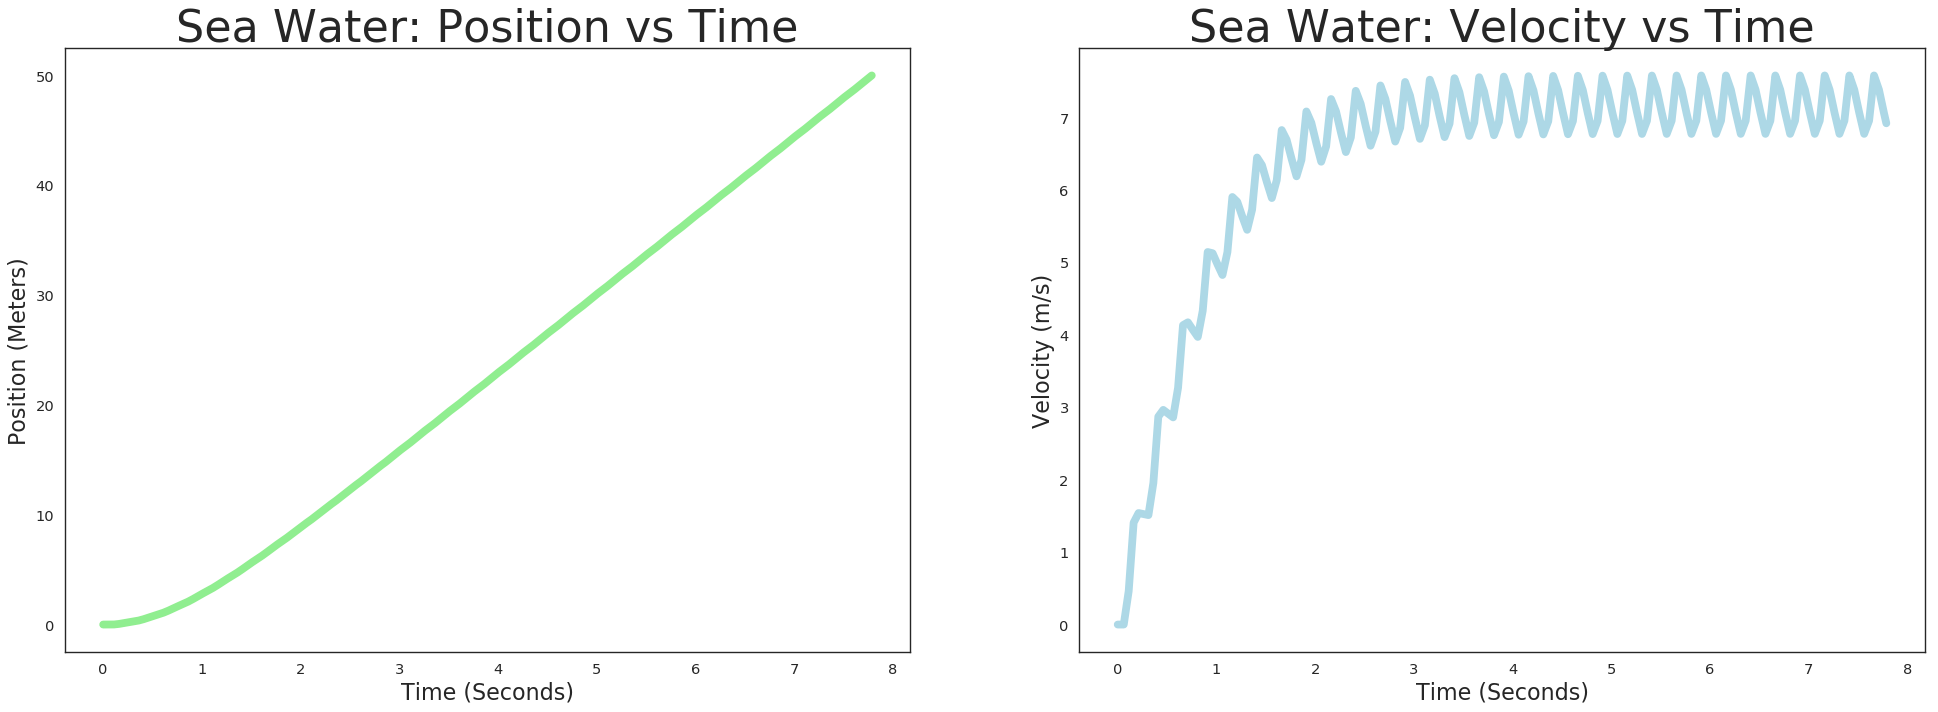

The total time it took the penguin to get to the end of the pool was 7.79 seconds.
The max speed of the penguin was 7.58 m/s or 27.29 kph.
The average speed of the penguin was 6.21 m/s or 22.36 kph.


In [32]:
params.rho = rho_sea_water
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.05)
analyze_results(results, system, 'Sea Water')

The original question that inspired us to make this model: What happens if a penguin swims in syrup? (Ignoring the sugary effect on the penguin. I choose to believe that the penguin would just want to eat it right up).

Penguin mass:  5.8967 kilogram
Fluid density:  1370.0 kilogram / meter ** 3


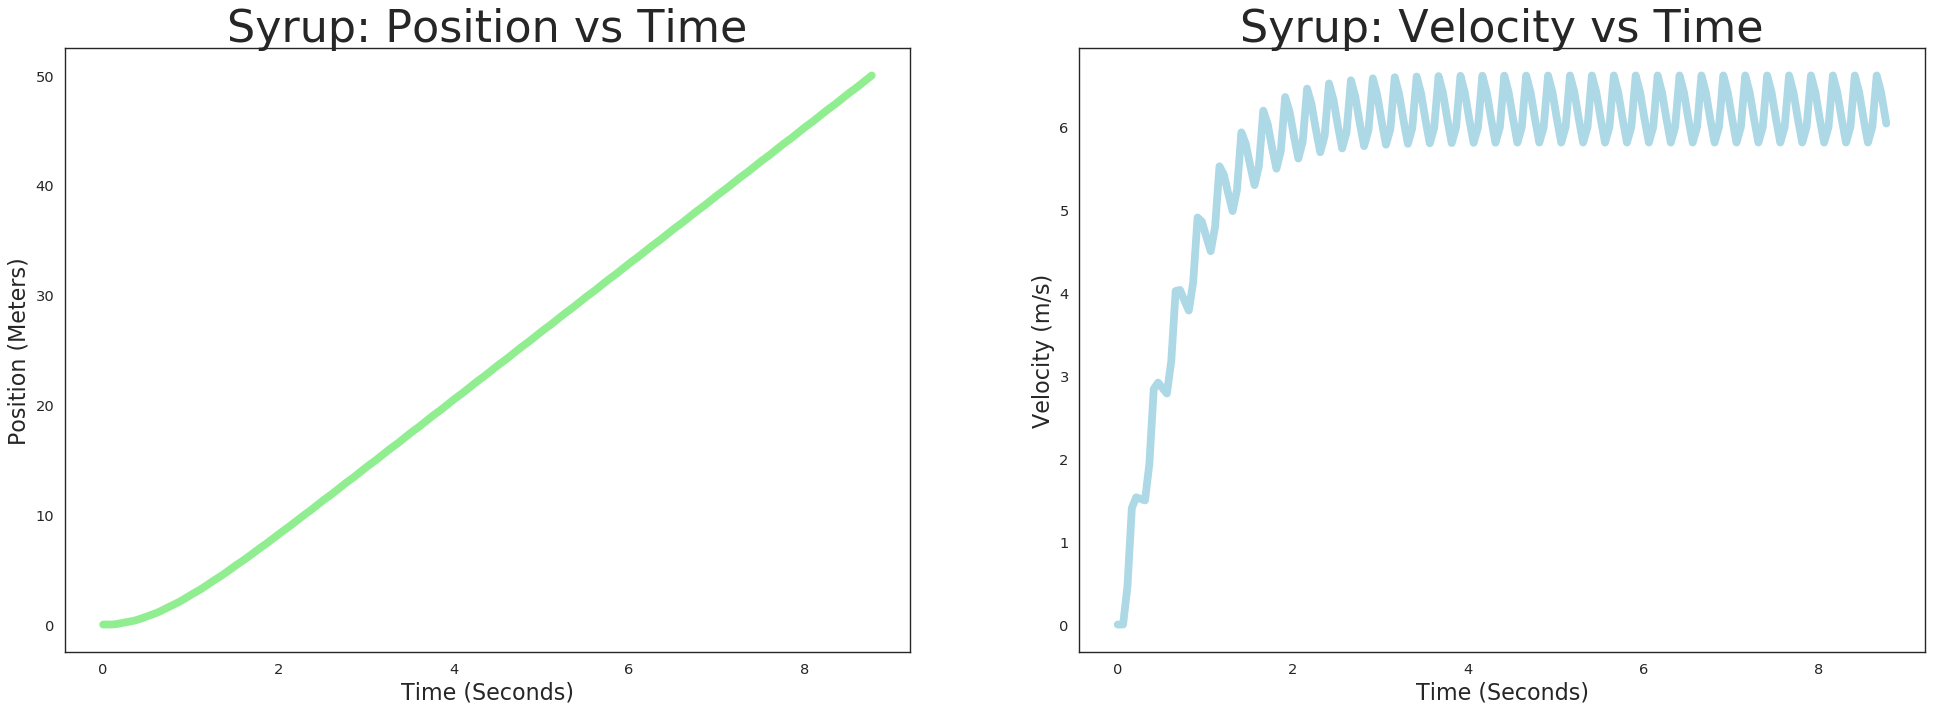

The total time it took the penguin to get to the end of the pool was 8.77 seconds.
The max speed of the penguin was 6.61 m/s or 23.81 kph.
The average speed of the penguin was 5.53 m/s or 19.92 kph.


In [31]:
params.rho = rho_syrup
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.05)
analyze_results(results, system, 'Syrup')

Penguin mass:  5.8967 kilogram
Fluid density:  800.0 kilogram / meter ** 3


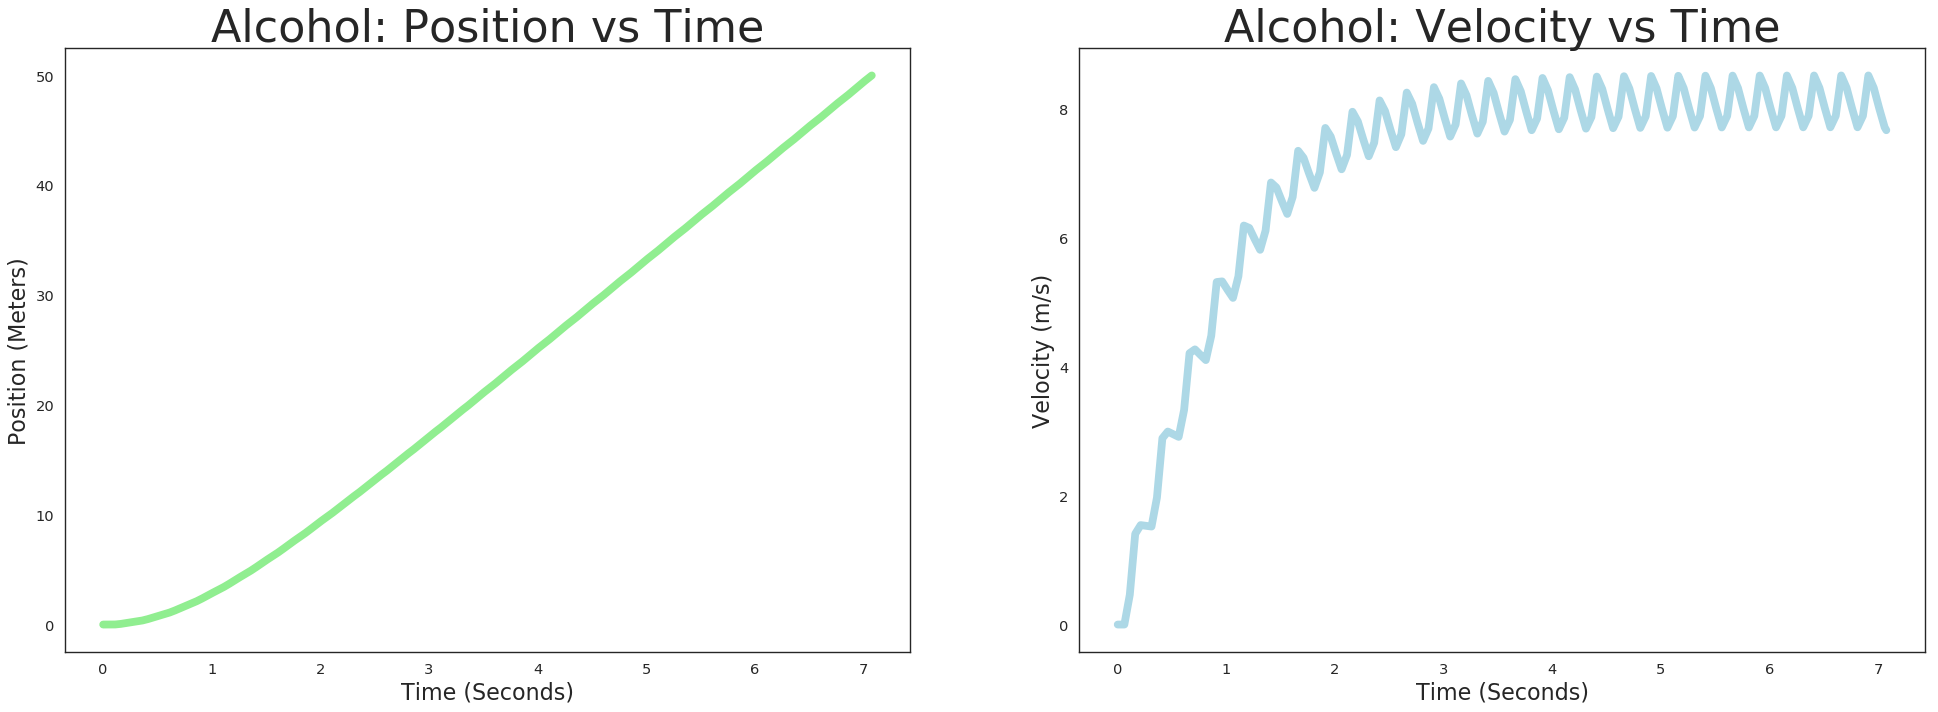

The total time it took the penguin to get to the end of the pool was 7.08 seconds.
The max speed of the penguin was 8.52 m/s or 30.68 kph.
The average speed of the penguin was 6.81 m/s or 24.53 kph.


In [33]:
params.rho = rho_propyl_alcohol
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.05)
analyze_results(results, system, 'Alcohol')

# Interpretation